# Required

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import os
import pandas as pd
import zipfile
import numpy as np
from torchvision import transforms
from torchvision.transforms import functional as F
from PIL import Image
import shutil
from sklearn.model_selection import train_test_split

import torch.optim as optim
from torch.optim import SGD
from tqdm import tqdm
import torchvision.transforms as T

import torchvision
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision.datasets import CocoDetection
from torchvision.models.detection import fasterrcnn_resnet50_fpn
from torchvision.models.detection.rpn import AnchorGenerator
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torchvision.ops import box_iou

In [3]:
!pip install ultralytics

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 914.6/914.6 kB 51.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 2.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 106.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 74.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 56.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 4.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 37.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 17.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 4.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 62.0 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninsta

In [4]:
# Set paths for dataset
data_dir = '/content/drive/MyDrive/ColabNotebooks/'
train_zip = os.path.join(data_dir, 'TrainIJCNN2013.zip')
test_zip = os.path.join(data_dir, 'TestIJCNN2013.zip')
annotations_file = '/content/drive/MyDrive/ColabNotebooks/gt.txt'


# -*- coding: utf-8 -*-
"""GTSDB_Faster_RCNN.ipynb"""

# Import necessary libraries
import os
import zipfile
import torch
import torchvision.transforms as T
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np


# Extract the dataset
train_dir = '/content/train/TrainIJCNN2013'
test_dir = '/content/test/TestIJCNN2013Download'

os.makedirs(train_dir, exist_ok=True)
os.makedirs(test_dir, exist_ok=True)

with zipfile.ZipFile(train_zip, 'r') as zip_ref:
    zip_ref.extractall('/content')
with zipfile.ZipFile(test_zip, 'r') as zip_ref:
    zip_ref.extractall('/content')

print("Dataset extracted successfully.")

train_dir = 'TrainIJCNN2013'
validation_dir = 'TestIJCNN2013Download'

Dataset extracted successfully.


In [5]:
import torch
import os

def parse_annotations(annotations_file, image_dir):
    annotations = []

    # Φόρτωση των annotations
    with open(annotations_file, "r") as f:
        for line_no, line in enumerate(f.readlines()):
            if line_no == 0:  # Παράλειψη της γραμμής επικεφαλίδας
                continue
            fields = line.strip().split(",")
            if len(fields) != 6:  # Αναμενόμενες στήλες: filename, x1, y1, x2, y2, class
                print(f"Skipping malformed line {line_no + 1}: {line.strip()}")
                continue
            filename, x1, y1, x2, y2, class_id = fields
            x1, y1, x2, y2 = float(x1), float(y1), float(x2), float(y2)
            class_id = int(class_id)
            # Έλεγχος για bounding boxes εκτός ορίων εικόνας
            if x1 < 0 or y1 < 0 or x2 > 2048 or y2 > 2048:
                print(f"Skipping bounding box out of bounds: {filename}, [{x1}, {y1}, {x2}, {y2}]")
                continue
            # Έλεγχος για μη έγκυρα bounding boxes
            if x1 >= x2 or y1 >= y2:
                print(f"Skipping invalid bounding box at line {line_no + 1}: [{x1}, {y1}, {x2}, {y2}]")
                continue
            # Έλεγχος για πολύ μικρά bounding boxes
            if abs(x2 - x1) < 10 or abs(y2 - y1) < 10:
                print(f"Skipping small bounding box at line {line_no + 1}: [{x1}, {y1}, {x2}, {y2}]")
                continue
            # Προσθήκη στα annotations
            annotations.append({
                "filename": filename,
                "bbox": [x1, y1, x2, y2],
                "label": class_id
            })

    return annotations
    return annotations


# Example usage
annotations = parse_annotations(annotations_file, train_dir)

# Check the first few annotations to verify the format
print(annotations[:5])
annotations = parse_annotations(annotations_file, train_dir)
print(f"Parsed Annotations: {annotations[:5]}")  # Εμφάνιση των πρώτων 5 γραμμών
print(f"Total annotations: {len(annotations)}")

[{'filename': '/content/TrainIJCNN2013/00000.ppm', 'bbox': [774.0, 411.0, 815.0, 446.0], 'label': 11}, {'filename': '/content/TrainIJCNN2013/00001.ppm', 'bbox': [983.0, 388.0, 1024.0, 432.0], 'label': 40}, {'filename': '/content/TrainIJCNN2013/00001.ppm', 'bbox': [386.0, 494.0, 442.0, 552.0], 'label': 38}, {'filename': '/content/TrainIJCNN2013/00001.ppm', 'bbox': [973.0, 335.0, 1031.0, 390.0], 'label': 13}, {'filename': '/content/TrainIJCNN2013/00002.ppm', 'bbox': [892.0, 476.0, 1006.0, 592.0], 'label': 39}]
Parsed Annotations: [{'filename': '/content/TrainIJCNN2013/00000.ppm', 'bbox': [774.0, 411.0, 815.0, 446.0], 'label': 11}, {'filename': '/content/TrainIJCNN2013/00001.ppm', 'bbox': [983.0, 388.0, 1024.0, 432.0], 'label': 40}, {'filename': '/content/TrainIJCNN2013/00001.ppm', 'bbox': [386.0, 494.0, 442.0, 552.0], 'label': 38}, {'filename': '/content/TrainIJCNN2013/00001.ppm', 'bbox': [973.0, 335.0, 1031.0, 390.0], 'label': 13}, {'filename': '/content/TrainIJCNN2013/00002.ppm', 'bbox

# YOLO v3

In [6]:
def convert_gt_to_yolo(gt_file, output_dir, image_width, image_height):
    """Μετατροπή των annotations από το gt.txt στο YOLO format."""
    os.makedirs(output_dir, exist_ok=True)

    with open(gt_file, "r") as f:
        lines = f.readlines()

    # Παράλειψη της κεφαλίδας
    lines = lines[1:]

    for line in lines:
        parts = line.strip().split(",")  # Χρήση "," αντί για απλό split

        if len(parts) != 6:  # Αν η γραμμή δεν έχει 6 στοιχεία, παράβλεψέ την
            print(f"Skipping invalid line: {line.strip()}")
            continue

        filename, x_min, y_min, x_max, y_max, class_id = parts
        x_min, y_min, x_max, y_max, class_id = map(int, [x_min, y_min, x_max, y_max, class_id])

        # Υπολογισμός YOLO συντεταγμένων
        x_center = ((x_min + x_max) / 2) / image_width
        y_center = ((y_min + y_max) / 2) / image_height
        width = (x_max - x_min) / image_width
        height = (y_max - y_min) / image_height

        yolo_annotation = f"{class_id} {x_center:.6f} {y_center:.6f} {width:.6f} {height:.6f}"

        # Αποθήκευση του YOLO annotation
        output_file = os.path.join(output_dir, os.path.splitext(os.path.basename(filename))[0] + ".txt")
        with open(output_file, "w") as f:
            f.write(yolo_annotation + "\n")

# Εκτέλεση μετατροπής
output_train_labels_dir = "train/labels"
output_validate_labels_dir = "validation/labels"
output_test_labels_dir = "test/labels"
image_width = 1360
image_height = 800

convert_gt_to_yolo(annotations_file, output_train_labels_dir, image_width, image_height)
convert_gt_to_yolo(annotations_file, output_validate_labels_dir, image_width, image_height)
convert_gt_to_yolo(annotations_file, output_test_labels_dir, image_width, image_height)

print("Train labels:", len(os.listdir(output_train_labels_dir)))
print("Test labels:", len(os.listdir(output_validate_labels_dir)))
print("Test labels:", len(os.listdir(output_test_labels_dir)))

Train labels: 506
Test labels: 506
Test labels: 506


In [ ]:
from pathlib import Path
from PIL import Image

def convert_ppm_to_jpg(input_dir):
    """
    Μετατρέπει όλα τα .ppm αρχεία σε .jpg μέσα σε έναν κατάλογο.

    Args:
        input_dir (str ή Path): Ο κατάλογος που περιέχει τις εικόνες .ppm.

    Returns:
        None
    """
    input_path = Path(input_dir)  # Μετατροπή σε Path object αν είναι string

    for ppm_file in input_path.rglob("*.ppm"):
        img = Image.open(ppm_file)
        new_file = ppm_file.with_suffix(".jpg")  # Μετατροπή σε .jpg
        img.save(new_file)
        print(f"Converted {ppm_file} to {new_file}")
        # Διαγραφη του αρχικυ .ppm αρχειου
        ppm_file.unlink()

convert_ppm_to_jpg("/content/TrainIJCNN2013")
convert_ppm_to_jpg("/content/TestIJCNN2013Download")

In [8]:
import os
import random
import shutil

# Ορισμός των paths
dataset_dir = "/content/TestIJCNN2013Download"
val_dir = "validation/images"
test_dir = "test/images"

# Δημιουργία φακέλων αν δεν υπάρχουν
os.makedirs(val_dir, exist_ok=True)
os.makedirs(test_dir, exist_ok=True)

# Λίστα με όλα τα αρχεία εικόνων
image_files = [f for f in os.listdir(dataset_dir) if f.endswith(('.jpg', '.png'))]

# Ανακάτεμα εικόνων
random.seed(42)  # Για σταθερά αποτελέσματα
random.shuffle(image_files)

# Υπολογισμός του αριθμού των εικόνων για validation (35%)
num_validation = int(len(image_files) * 0.35)

# Διαχωρισμός εικόνων
validation_images = image_files[:num_validation]
test_images = image_files[num_validation:]

# Μετακίνηση των εικόνων στους αντίστοιχους φακέλους
for img in validation_images:
    shutil.move(os.path.join(dataset_dir, img), os.path.join(val_dir, img))

for img in test_images:
    shutil.move(os.path.join(dataset_dir, img), os.path.join(test_dir, img))

print(f"Διαχωρισμός ολοκληρώθηκε επιτυχώς. Validation: {len(validation_images)} εικόνες, Test: {len(test_images)} εικόνες")

Διαχωρισμός ολοκληρώθηκε επιτυχώς. Validation: 105 εικόνες, Test: 195 εικόνες


In [9]:
# Ορισμός paths
dataset_dir = "/content/TrainIJCNN2013"
train_dir = 'train/images'

# Διατρέχουμε τον φάκελο και αντιγράφουμε αρχεία και υποφακέλους
for root, dirs, files in os.walk(dataset_dir):
    for dir_name in dirs:
        source_subfolder = os.path.join(root, dir_name)
        destination_subfolder = os.path.join(train_dir, dir_name)

        # Δημιουργία του φακέλου προορισμού αν δεν υπάρχει
        os.makedirs(destination_subfolder, exist_ok=True)

        # Αντιγραφή αρχείων εικόνων από τους υποφακέλους
        for file_name in os.listdir(source_subfolder):
            if file_name.endswith((".jpg", ".png")):  # Έλεγχος αν είναι εικόνα
                source_path = os.path.join(source_subfolder, file_name)
                destination_path = os.path.join(destination_subfolder, file_name)
                shutil.copy(source_path, destination_path)

    # Αντιγραφή των εικόνων που βρίσκονται απευθείας στο TrainIJCNN2013
    for file_name in files:
        if file_name.endswith((".jpg", ".png")):
            source_path = os.path.join(root, file_name)
            destination_path = os.path.join(train_dir, file_name)
            shutil.copy(source_path, destination_path)

print("Όλες οι εικόνες αντιγράφηκαν επιτυχώς με τη σωστή δομή!")

Όλες οι εικόνες αντιγράφηκαν επιτυχώς με τη σωστή δομή!


In [10]:
data_yaml = """
path: /content
train: train
val: validation
test: test

names:
  - Speed limit (20km/h)
  - Speed limit (30km/h)
  - Speed limit (50km/h)
  - Speed limit (60km/h)
  - Speed limit (70km/h)
  - Speed limit (80km/h)
  - End of speed limit (80km/h)
  - Speed limit (100km/h)
  - Speed limit (120km/h)
  - No passing
  - No passing veh over 3.5 tons
  - Right-of-way at intersection
  - Priority road
  - Yield
  - Stop
  - No vehicles
  - Veh > 3.5 tons prohibited
  - No entry
  - General caution
  - Dangerous curve left
  - Dangerous curve right
  - Double curve
  - Bumpy road
  - Slippery road
  - Road narrows on the right
  - Road work
  - Traffic signals
  - Pedestrians
  - Children crossing
  - Bicycles crossing
  - Beware of ice/snow
  - Wild animals crossing
  - End speed + passing limits
  - Turn right ahead
  - Turn left ahead
  - Ahead only
  - Go straight or right
  - Go straight or left
  - Keep right
  - Keep left
  - Roundabout mandatory
  - End of no passing
  - End no passing veh > 3.5 tons
"""

# Αποθήκευση του αρχείου
with open("/content/data.yaml", "w") as f:
    f.write(data_yaml)

print("Το αρχείο data.yaml δημιουργήθηκε σωστά!")

Το αρχείο data.yaml δημιουργήθηκε σωστά!


In [1]:
from ultralytics import YOLO

# Load YOLOv3 model
model = YOLO("yolov3.yaml")

# Train the model
model.train(data="/content/data.yaml", epochs=10, imgsz=416, batch=32, device=0)

Ultralytics 8.3.73 🚀 Python-3.11.11 torch-2.5.1+cu124 CUDA:0 (Tesla T4, 15095MiB)
engine/trainer: task=detect, mode=train, model=yolov3.yaml, data=/content/data.yaml, epochs=10, time=None, patience=100, batch=32, imgsz=416, save=True, save_period=-1, cache=False, device=0, workers=8, project=None, name=train2, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, embed=None, show=False, save_frames=False, save_txt=False, save_conf=False, save_crop=False, show_labels=True, show_conf=True, show_boxes=True, li

train: Scanning /content/train/labels/00... 506 images, 947 backgrounds, 0 corrupt: 100%|██████████| 1453/1453 [00:00<00:00, 2098.99it/s]


train: New cache created: /content/train/labels/00.cache
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))


val: Scanning /content/validation/labels... 102 images, 3 backgrounds, 0 corrupt: 100%|██████████| 105/105 [00:00<00:00, 1298.28it/s]

val: New cache created: /content/validation/labels.cache


Plotting labels to runs/detect/train2/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.000213, momentum=0.9) with parameter groups 84 weight(decay=0.0), 91 weight(decay=0.0005), 90 bias(decay=0.0)
TensorBoard: model graph visualization added ✅
Image sizes 416 train, 416 val
Using 8 dataloader workers
Logging results to runs/detect/train2
Starting training for 10 epochs...
Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/10      12.4G      1.727      102.3      1.108          5        416: 100%|██████████| 46/46 [00:44<00:00,  1.04it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.30it/s]

                   all        105        102          0          0          0          0



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/10      12.3G      1.775      77.26      1.051          3        416: 100%|██████████| 46/46 [00:43<00:00,  1.07it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.35it/s]

                   all        105        102          0          0          0          0



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/10        13G      2.613         63      1.666          3        416: 100%|██████████| 46/46 [00:43<00:00,  1.06it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.35it/s]

                   all        105        102          0          0          0          0



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/10        13G      3.021       53.4      1.695          3        416: 100%|██████████| 46/46 [00:44<00:00,  1.04it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.31it/s]

                   all        105        102          0          0          0          0



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/10      12.8G      2.971      44.71      1.525          4        416: 100%|██████████| 46/46 [00:44<00:00,  1.03it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.26it/s]

                   all        105        102          0          0          0          0



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/10      13.1G      3.815      34.13       1.91          3        416: 100%|██████████| 46/46 [00:45<00:00,  1.01it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.27it/s]

                   all        105        102          0          0          0          0



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/10      13.1G      4.003      27.26      1.975          4        416: 100%|██████████| 46/46 [00:45<00:00,  1.01it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.19it/s]

                   all        105        102          0          0          0          0



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/10      13.1G      3.841      19.14      1.738          4        416: 100%|██████████| 46/46 [00:45<00:00,  1.01it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.23it/s]

                   all        105        102          0          0          0          0



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/10        13G      3.612      19.23      1.657          4        416: 100%|██████████| 46/46 [00:45<00:00,  1.01it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.23it/s]

                   all        105        102          0          0          0          0



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/10        13G      3.749      18.67      1.701          2        416: 100%|██████████| 46/46 [00:45<00:00,  1.01it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.26it/s]

                   all        105        102          0          0          0          0



10 epochs completed in 0.138 hours.
Optimizer stripped from runs/detect/train2/weights/last.pt, 207.8MB
Optimizer stripped from runs/detect/train2/weights/best.pt, 207.8MB

Validating runs/detect/train2/weights/best.pt...
Ultralytics 8.3.73 🚀 Python-3.11.11 torch-2.5.1+cu124 CUDA:0 (Tesla T4, 15095MiB)
YOLOv3 summary (fused): 226 layers, 103,697,393 parameters, 0 gradients, 282.4 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.28it/s]

                   all        105        102          0          0          0          0


Speed: 0.1ms preprocess, 7.1ms inference, 0.0ms loss, 0.1ms postprocess per image
Results saved to runs/detect/train2


AttributeError: 'DetMetrics' object has no attribute 'curves_results'. See valid attributes below.

    Utility class for computing detection metrics such as precision, recall, and mean average precision (mAP) of an
    object detection model.

    Args:
        save_dir (Path): A path to the directory where the output plots will be saved. Defaults to current directory.
        plot (bool): A flag that indicates whether to plot precision-recall curves for each class. Defaults to False.
        on_plot (func): An optional callback to pass plots path and data when they are rendered. Defaults to None.
        names (dict of str): A dict of strings that represents the names of the classes. Defaults to an empty tuple.

    Attributes:
        save_dir (Path): A path to the directory where the output plots will be saved.
        plot (bool): A flag that indicates whether to plot the precision-recall curves for each class.
        on_plot (func): An optional callback to pass plots path and data when they are rendered.
        names (dict of str): A dict of strings that represents the names of the classes.
        box (Metric): An instance of the Metric class for storing the results of the detection metrics.
        speed (dict): A dictionary for storing the execution time of different parts of the detection process.

    Methods:
        process(tp, conf, pred_cls, target_cls): Updates the metric results with the latest batch of predictions.
        keys: Returns a list of keys for accessing the computed detection metrics.
        mean_results: Returns a list of mean values for the computed detection metrics.
        class_result(i): Returns a list of values for the computed detection metrics for a specific class.
        maps: Returns a dictionary of mean average precision (mAP) values for different IoU thresholds.
        fitness: Computes the fitness score based on the computed detection metrics.
        ap_class_index: Returns a list of class indices sorted by their average precision (AP) values.
        results_dict: Returns a dictionary that maps detection metric keys to their computed values.
        curves: TODO
        curves_results: TODO
    

In [11]:
import os

label_path = "/content/train/labels"
invalid_labels = []

for file in os.listdir(label_path):
    if file.endswith(".txt"):
        with open(os.path.join(label_path, file), "r") as f:
            lines = f.readlines()
            for line in lines:
                class_id = int(line.split()[0])
                if class_id > 41:  # Εφόσον `nc=42`, οι κλάσεις πρέπει να είναι 0-41
                    invalid_labels.append((file, class_id))

print(f"Βρέθηκαν {len(invalid_labels)} labels με μη έγκυρη κλάση!")

for file, class_id in invalid_labels:
    file_path = os.path.join(label_path, file)
    with open(file_path, "r") as f:
        lines = f.readlines()

    new_lines = [line for line in lines if int(line.split()[0]) <= 41]

    with open(file_path, "w") as f:
        f.writelines(new_lines)

print("Τα labels διορθώθηκαν!")

Βρέθηκαν 0 labels με μη έγκυρη κλάση!
Τα labels διορθώθηκαν!


In [12]:
import numpy as np

def check_bboxes(label_folder):
    """Ελέγχει αν υπάρχουν bounding boxes με πολύ μικρές ή μεγάλες τιμές"""
    bad_boxes = []

    for file in os.listdir(label_folder):
        if file.endswith(".txt"):
            with open(os.path.join(label_folder, file), "r") as f:
                lines = f.readlines()
                for line in lines:
                    parts = line.split()
                    if len(parts) != 5:
                        continue
                    _, x_center, y_center, width, height = map(float, parts)
                    if width <= 0.01 or height <= 0.01 or width > 1 or height > 1:
                        bad_boxes.append((file, x_center, y_center, width, height))

    return bad_boxes

bad_boxes = check_bboxes("/content/train/labels")

if bad_boxes:
    print("Βρέθηκαν bounding boxes με λανθασμένα μεγέθη:")
    print(bad_boxes[:10])  # Δείξε τα πρώτα 10
else:
    print("Όλα τα bounding boxes φαίνονται σωστά!")


Όλα τα bounding boxes φαίνονται σωστά!


In [13]:
import cv2
import matplotlib.pyplot as plt
from ultralytics import YOLO

def visualize_yolo_detections(image_path, model, confidence_threshold=0.5):
    """
    Visualize YOLO predictions on an image.

    Args:
    - image_path: Path to the input image.
    - model: YOLO model object.
    - confidence_threshold: Minimum confidence for displaying detections.
    """
    # Perform inference
    results = model(image_path)  # Run YOLO on the input image

    # Convert image for visualization
    img = cv2.imread(image_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    # Process detections
    detections = results[0].boxes  # Access the boxes property
    for det in detections:
        # Extract bounding box, confidence, and class
        box = det.xyxy.cpu().numpy()[0]  # xyxy format
        conf = det.conf.cpu().numpy()[0]  # Confidence score
        cls = int(det.cls.cpu().numpy()[0])  # Class index

        if conf < confidence_threshold:
            continue

        # Draw bounding box
        x1, y1, x2, y2 = map(int, box)
        cv2.rectangle(img, (x1, y1), (x2, y2), (0, 255, 0), 2)

        # Add label
        label = f"{model.names[cls]} {conf:.2f}"
        cv2.putText(img, label, (x1, y1 - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255, 0, 0), 2)

    # Display the image with matplotlib
    plt.figure(figsize=(10, 10))
    plt.imshow(img)
    plt.axis("off")
    plt.title("YOLO Detections")
    plt.show()

In [16]:
# Load the trained YOLO model
model = YOLO("/content/yolo11n.pt")  # Load the trained YOLOv3 model

import os
import numpy as np
# Test images directory
test_images_dir = 'test'
os.makedirs(test_images_dir, exist_ok=True)

# List all test images
test_images = os.listdir(test_images_dir)

# Visualize predictions for a few images
for i in range(5):  # Visualize first 5 images
    image_path = os.path.join(test_images_dir, test_images[i])
    print(f"Visualizing predictions for: {test_images[i]}")
    visualize_yolo_detections(image_path, model, confidence_threshold=0.5)

Visualizing predictions for: images

image 1/255 /content/test/images/00001.jpg: 384x640 6 cars, 11.2ms
image 2/255 /content/test/images/00002.jpg: 384x640 1 car, 2 trucks, 8.9ms
image 3/255 /content/test/images/00003.jpg: 384x640 5 cars, 9.2ms
image 4/255 /content/test/images/00005.jpg: 384x640 4 cars, 8.9ms
image 5/255 /content/test/images/00006.jpg: 384x640 8 cars, 8.9ms
image 6/255 /content/test/images/00007.jpg: 384x640 8 cars, 1 truck, 9.7ms
image 7/255 /content/test/images/00008.jpg: 384x640 8 cars, 1 truck, 6 traffic lights, 8.9ms
image 8/255 /content/test/images/00009.jpg: 384x640 6 cars, 1 bus, 1 stop sign, 8.9ms
image 9/255 /content/test/images/00010.jpg: 384x640 8 cars, 2 trucks, 8.6ms
image 10/255 /content/test/images/00011.jpg: 384x640 6 cars, 1 bus, 1 truck, 8.7ms
image 11/255 /content/test/images/00012.jpg: 384x640 4 cars, 8.9ms
image 12/255 /content/test/images/00013.jpg: 384x640 1 car, 8.6ms
image 13/255 /content/test/images/00014.jpg: 384x640 2 cars, 8.9ms
image 14/2

error: OpenCV(4.11.0) /io/opencv/modules/imgproc/src/color.cpp:199: error: (-215:Assertion failed) !_src.empty() in function 'cvtColor'


In [18]:

import torch
import numpy as np
from tqdm import tqdm
from torchvision.ops import box_iou

def calculate_map(model, dataloader, device, iou_threshold=0.15):
    """
    Υπολογίζει το mAP (Mean Average Precision) για το Faster R-CNN.
    """
    model.eval()
    precisions, recalls = [], []

    with torch.no_grad():
        for images, targets in tqdm(dataloader, desc="Evaluating Faster R-CNN"):
            images = [img.to(device) for img in images]
            targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

            # Προβλέψεις από το Faster R-CNN
            predictions = model(images)

            for img_idx, prediction in enumerate(predictions):
                pred_boxes = prediction["boxes"].cpu()
                pred_scores = prediction["scores"].cpu()
                gt_boxes = targets[img_idx]["boxes"].cpu()

                # Αν δεν υπάρχουν GT boxes, προσπέρασε το frame
                if len(gt_boxes) == 0:
                    print(f"⚠ Warning: No ground truth boxes for image {img_idx}")
                    continue

                if len(pred_boxes) == 0:
                    print(f"⚠ Warning: No predicted boxes for image {img_idx}")
                    continue

                # Υπολογισμός IoU
                ious = box_iou(pred_boxes, gt_boxes)
                max_iou, _ = ious.max(dim=1)

                # Κρατάμε μόνο detections με IoU > threshold
                valid_detections = max_iou > iou_threshold
                tp = valid_detections.sum().item()
                fp = len(pred_boxes) - tp
                fn = max(len(gt_boxes) - tp, 1)

                precision = tp / max(tp + fp, 1e-6)
                recall = tp / (tp + fn)  # FN Ποτέ 0

                precisions.append(precision)
                recalls.append(recall)

                print(f"Image {img_idx}: TP={tp}, FP={fp}, FN={fn}, Precision={precision:.4f}, Recall={recall:.4f}")

    mean_precision = np.mean(precisions)
    mean_recall = np.mean(recalls)
    map_score = mean_precision * mean_recall  # Κανονικοποίηση

    print(f"Precision: {mean_precision:.4f}, Recall: {mean_recall:.4f}, mAP: {map_score:.4f}")

    return map_score


# Εκτέλεση αξιολόγησης
print("Evaluating Model Performance...")
map_score = calculate_map(model, 'test', device)

Evaluating Model Performance...


NameError: name 'device' is not defined

# LAB

In [ ]:
CLASS_NAME_TO_ID = {"RBC": 0, "WBC": 1, "Platelets": 2}

def fix_yolo_labels(label_dir):
    """
    Convert class names to numeric IDs in YOLO label files.
    Args:
    - label_dir: Directory containing YOLO label files.
    """
    for label_file in os.listdir(label_dir):
        if label_file.endswith(".txt"):
            label_path = os.path.join(label_dir, label_file)
            fixed_labels = []

            with open(label_path, "r") as f:
                for line in f:
                    parts = line.strip().split()
                    class_name = parts[0]
                    bbox = parts[1:]

                    # Convert class name to numeric ID
                    if class_name in CLASS_NAME_TO_ID:
                        class_id = CLASS_NAME_TO_ID[class_name]
                        fixed_labels.append(f"{class_id} {' '.join(bbox)}")
                    else:
                        print(f"Skipping unknown class '{class_name}' in {label_file}")

            # Overwrite the label file with fixed labels
            with open(label_path, "w") as f:
                f.write("\n".join(fixed_labels))

# Fix labels for train, val, and test sets
fix_yolo_labels("BCCD/train/labels")
fix_yolo_labels("BCCD/valid/labels")
fix_yolo_labels("BCCD/test/labels")

In [ ]:
import os
import shutil

def organize_images(image_dir, destination_dir):
    """

    Move all images to the correct 'images/' subdirectory.
    Args:
    - image_dir: Directory containing the images.
    - destination_dir: Target 'images/' directory.
    """
    os.makedirs(destination_dir, exist_ok=True)

    for file in os.listdir(image_dir):
        if file.endswith((".jpg", ".png", ".jpeg")):  # Include valid image formats
            source_path = os.path.join(image_dir, file)
            destination_path = os.path.join(destination_dir, file)
            shutil.move(source_path, destination_path)

# Organize images into 'images/' subfolders
organize_images("BCCD/train", "BCCD/train/images")
organize_images("BCCD/valid", "BCCD/valid/images")
organize_images("BCCD/test", "BCCD/test/images")

Για να τρέξουμε την εκπαίδευση του yolo χρειαζεται να ορίσουμε και το data.yaml το οποίο περιέχει τις πληροφορίες για το path των train, val & test sets, καθώς και για τις κλάσεις

Πρέπει να είναι αυτής της μορφής:
path: /content/BCCD
train: train
val: valid
test: test

names:
    0: RBC
    1: WBC
    2: Platelets

In [ ]:
from ultralytics import YOLO

# Load YOLOv3 model
model = YOLO("yolov3.yaml")  # Specify the YOLOv3 architecture

# Train the model
model.train(data="data.yaml", epochs=10, imgsz=416, batch=32, device=0)

Ultralytics 8.3.51 🚀 Python-3.10.12 torch-2.5.1+cu121 CUDA:0 (NVIDIA A100-SXM4-40GB, 40514MiB)
engine/trainer: task=detect, mode=train, model=yolov3.yaml, data=data.yaml, epochs=10, time=None, patience=100, batch=32, imgsz=416, save=True, save_period=-1, cache=False, device=0, workers=8, project=None, name=train16, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, embed=None, show=False, save_frames=False, save_txt=False, save_conf=False, save_crop=False, show_labels=True, show_conf=True, show_boxes=Tru

100%|██████████| 755k/755k [00:00<00:00, 22.6MB/s]


Overriding model.yaml nc=80 with nc=3

                   from  n    params  module                                       arguments                     
  0                  -1  1       928  ultralytics.nn.modules.conv.Conv             [3, 32, 3, 1]                 
  1                  -1  1     18560  ultralytics.nn.modules.conv.Conv             [32, 64, 3, 2]                
  2                  -1  1     37056  ultralytics.nn.modules.block.Bottleneck      [64, 64]                      
  3                  -1  1     73984  ultralytics.nn.modules.conv.Conv             [64, 128, 3, 2]               
  4                  -1  2    295680  ultralytics.nn.modules.block.Bottleneck      [128, 128]                    
  5                  -1  1    295424  ultralytics.nn.modules.conv.Conv             [128, 256, 3, 2]              
  6                  -1  8   4724736  ultralytics.nn.modules.block.Bottleneck      [256, 256]                    
  7                  -1  1   1180672  ultralytics

100%|██████████| 5.35M/5.35M [00:00<00:00, 114MB/s]


AMP: checks passed ✅


train: Scanning /content/BCCD/train/labels... 765 images, 0 backgrounds, 0 corrupt: 100%|██████████| 765/765 [00:00<00:00, 1124.99it/s]

train: New cache created: /content/BCCD/train/labels.cache


albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))


/usr/local/lib/python3.10/dist-packages/albumentations/__init__.py:24: UserWarning: A new version of Albumentations is available: 1.4.23 (you have 1.4.20). Upgrade using: pip install -U albumentations. To disable automatic update checks, set the environment variable NO_ALBUMENTATIONS_UPDATE to 1.
  check_for_updates()
val: Scanning /content/BCCD/valid/labels... 73 images, 0 backgrounds, 0 corrupt: 100%|██████████| 73/73 [00:00<00:00, 1033.18it/s]

val: New cache created: /content/BCCD/valid/labels.cache


Plotting labels to runs/detect/train16/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.001429, momentum=0.9) with parameter groups 84 weight(decay=0.0), 91 weight(decay=0.0005), 90 bias(decay=0.0)
TensorBoard: model graph visualization added ✅
Image sizes 416 train, 416 val
Using 8 dataloader workers
Logging results to runs/detect/train16
Starting training for 10 epochs...
Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/10      12.2G      3.659      3.229      4.084        362        416: 100%|██████████| 24/24 [00:07<00:00,  3.18it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.08it/s]

                   all         73        967    0.00702       0.15     0.0056    0.00106



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/10      12.2G      2.709      2.066      3.523        398        416: 100%|██████████| 24/24 [00:05<00:00,  4.37it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  4.44it/s]

                   all         73        967      0.121      0.277     0.0872     0.0677



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/10      12.2G      2.247      1.723      2.922        386        416: 100%|██████████| 24/24 [00:05<00:00,  4.62it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  4.84it/s]

                   all         73        967      0.841      0.167      0.117     0.0224



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/10      12.3G      1.958      1.463      2.478        353        416: 100%|██████████| 24/24 [00:05<00:00,  4.64it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  4.92it/s]

                   all         73        967      0.433      0.104     0.0412     0.0104



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/10      12.3G      1.832       1.35      2.281        390        416: 100%|██████████| 24/24 [00:05<00:00,  4.63it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  4.70it/s]

                   all         73        967      0.636      0.492      0.474      0.242



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/10      12.3G      1.653      1.212       2.11        394        416: 100%|██████████| 24/24 [00:05<00:00,  4.66it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  4.78it/s]

                   all         73        967      0.559      0.513      0.233      0.125



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/10      12.3G      1.561      1.152      2.004        341        416: 100%|██████████| 24/24 [00:05<00:00,  4.66it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  5.13it/s]

                   all         73        967      0.735      0.531      0.497      0.249



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/10      12.3G      1.481      1.082       1.93        349        416: 100%|██████████| 24/24 [00:05<00:00,  4.63it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  5.30it/s]

                   all         73        967      0.755      0.707      0.714      0.445



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/10      12.3G      1.424      1.042      1.885        370        416: 100%|██████████| 24/24 [00:05<00:00,  4.63it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  5.17it/s]

                   all         73        967       0.74      0.784      0.748      0.452



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/10      12.3G      1.392     0.9932       1.84        350        416: 100%|██████████| 24/24 [00:05<00:00,  4.65it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  5.25it/s]

                   all         73        967      0.804      0.789      0.788      0.509



10 epochs completed in 0.026 hours.
Optimizer stripped from runs/detect/train16/weights/last.pt, 207.7MB
Optimizer stripped from runs/detect/train16/weights/best.pt, 207.7MB

Validating runs/detect/train16/weights/best.pt...
Ultralytics 8.3.51 🚀 Python-3.10.12 torch-2.5.1+cu121 CUDA:0 (NVIDIA A100-SXM4-40GB, 40514MiB)
YOLOv3 summary (fused): 226 layers, 103,666,553 parameters, 0 gradients, 282.2 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.38it/s]


                   all         73        967      0.805      0.789      0.788      0.511
                   RBC         72        819      0.659      0.886      0.842      0.581
                   WBC         71         72      0.937          1      0.985      0.724
             Platelets         42         76       0.82      0.479      0.535      0.229
Speed: 0.1ms preprocess, 1.7ms inference, 0.0ms loss, 1.1ms postprocess per image
Results saved to runs/detect/train16


ultralytics.utils.metrics.DetMetrics object with attributes:

ap_class_index: array([0, 1, 2])
box: ultralytics.utils.metrics.Metric object
confusion_matrix: <ultralytics.utils.metrics.ConfusionMatrix object at 0x7d652dfbb1f0>
curves: ['Precision-Recall(B)', 'F1-Confidence(B)', 'Precision-Confidence(B)', 'Recall-Confidence(B)']
curves_results: [[array([          0,    0.001001,    0.002002,    0.003003,    0.004004,    0.005005,    0.006006,    0.007007,    0.008008,    0.009009,     0.01001,    0.011011,    0.012012,    0.013013,    0.014014,    0.015015,    0.016016,    0.017017,    0.018018,    0.019019,     0.02002,    0.021021,    0.022022,    0.023023,
          0.024024,    0.025025,    0.026026,    0.027027,    0.028028,    0.029029,     0.03003,    0.031031,    0.032032,    0.033033,    0.034034,    0.035035,    0.036036,    0.037037,    0.038038,    0.039039,     0.04004,    0.041041,    0.042042,    0.043043,    0.044044,    0.045045,    0.046046,    0.047047,
          0.04

In [ ]:
# Evaluate the model
metrics = model.val()
print(metrics)

# Save the model
model.export(format="torchscript")  # Save trained weights

Ultralytics 8.3.51 🚀 Python-3.10.12 torch-2.5.1+cu121 CUDA:0 (NVIDIA A100-SXM4-40GB, 40514MiB)
YOLOv3 summary (fused): 226 layers, 103,666,553 parameters, 0 gradients, 282.2 GFLOPs


val: Scanning /content/BCCD/valid/labels.cache... 73 images, 0 backgrounds, 0 corrupt: 100%|██████████| 73/73 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:02<00:00,  1.47it/s]


                   all         73        967      0.804      0.789      0.788      0.509
                   RBC         72        819      0.656      0.887      0.842      0.582
                   WBC         71         72      0.936          1      0.985      0.721
             Platelets         42         76       0.82       0.48      0.536      0.224
Speed: 0.1ms preprocess, 4.9ms inference, 0.0ms loss, 4.0ms postprocess per image
Results saved to runs/detect/train52
ultralytics.utils.metrics.DetMetrics object with attributes:

ap_class_index: array([0, 1, 2])
box: ultralytics.utils.metrics.Metric object
confusion_matrix: <ultralytics.utils.metrics.ConfusionMatrix object at 0x78b235724790>
curves: ['Precision-Recall(B)', 'F1-Confidence(B)', 'Precision-Confidence(B)', 'Recall-Confidence(B)']
curves_results: [[array([          0,    0.001001,    0.002002,    0.003003,    0.004004,    0.005005,    0.006006,    0.007007,    0.008008,    0.009009,     0.01001,    0.011011,    0.012012,  

'runs/detect/train5/weights/best.torchscript'

In [ ]:
import cv2
import matplotlib.pyplot as plt
from ultralytics import YOLO


def visualize_yolo_detections(image_path, model, confidence_threshold=0.5):
    """
    Visualize YOLO predictions on an image.

    Args:
    - image_path: Path to the input image.
    - model: YOLO model object.
    - confidence_threshold: Minimum confidence for displaying detections.
    """
    # Perform inference
    results = model(image_path)  # Run YOLO on the input image

    # Convert image for visualization
    img = cv2.imread(image_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    # Process detections
    detections = results[0].boxes  # Access the boxes property
    for det in detections:
        # Extract bounding box, confidence, and class
        box = det.xyxy.cpu().numpy()[0]  # xyxy format
        conf = det.conf.cpu().numpy()[0]  # Confidence score
        cls = int(det.cls.cpu().numpy()[0])  # Class index

        if conf < confidence_threshold:
            continue

        # Draw bounding box
        x1, y1, x2, y2 = map(int, box)
        cv2.rectangle(img, (x1, y1), (x2, y2), (0, 255, 0), 2)

        # Add label
        label = f"{model.names[cls]} {conf:.2f}"
        cv2.putText(img, label, (x1, y1 - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255, 0, 0), 2)

    # Display the image with matplotlib
    plt.figure(figsize=(10, 10))
    plt.imshow(img)
    plt.axis("off")
    plt.title("YOLO Detections")
    plt.show()


image 1/1 /content/BCCD/test/images/BloodImage_00038_jpg.rf.ffa23e4b5b55b523367f332af726eae8.jpg: 416x416 15 RBCs, 1 WBC, 1 Platelets, 9.9ms
Speed: 0.9ms preprocess, 9.9ms inference, 1.6ms postprocess per image at shape (1, 3, 416, 416)


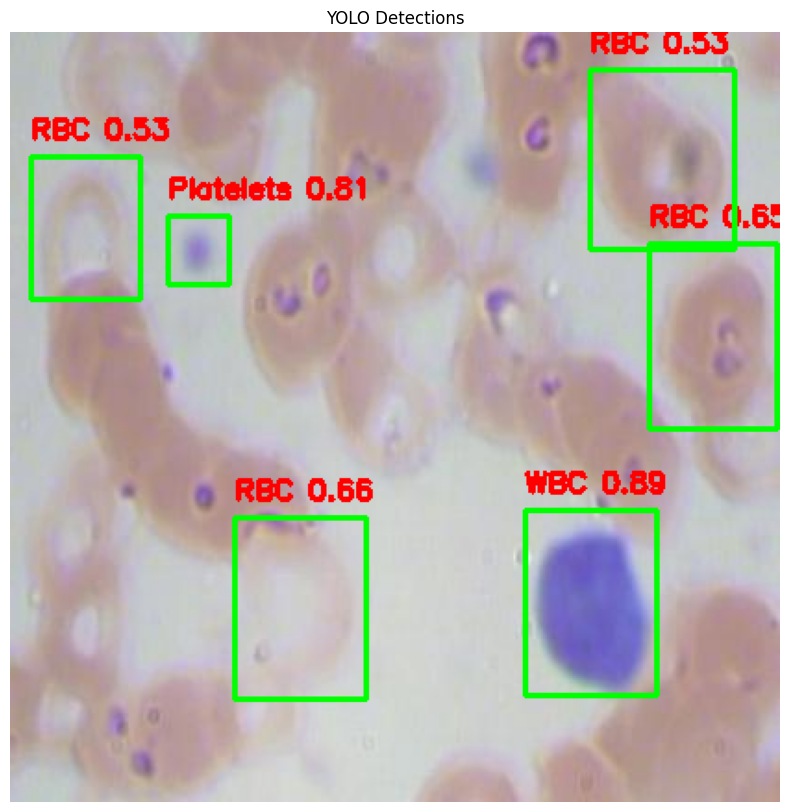

In [ ]:
# Load the trained YOLO model
model = YOLO("/content/runs/detect/train5/weights/best.pt")  # Load the trained YOLOv3 model

# Test on an image from the dataset
image_path = "/content/BCCD/test/images/BloodImage_00038_jpg.rf.ffa23e4b5b55b523367f332af726eae8.jpg"  # Replace with an actual test image path
visualize_yolo_detections(image_path, model, confidence_threshold=0.5)